### Project Chicago: Transform ResStock UPGRADE Results to Multi-family (RECS) Building Types
Created on: 12/15/2020 \
By: Lixi Liu (Lixi.Liu@nrel.gov)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
print(f'Notebook path: {os.getcwd()}')

Notebook path: /Users/lliu2/Documents/GitHub/ResStock/files


### Download results online
* unprocessed upgrade results: S3/resbldg-datasets/chicagoeui
* processed result tables for plots: https://nrel.sharepoint.com/sites/ChicagoRetrofits/Shared%20Documents/Forms/AllItems.aspx?viewid=289cdd1a%2D97c9%2D4bcc%2D8416%2Dc19bf01c6302&id=%2Fsites%2FChicagoRetrofits%2FShared%20Documents%2FGeneral%2FUpgrade%20results

### Initialize
For modifying plots, can go directly to section 2.3 after initialization

In [2]:
# local path to downloaded results
iteration = '03_mf' # <----- options: '02a', '02b'
iter_path = f'cookcnty_upgrades_{iteration}'
result_dir = '/Users/lliu2/Documents/Chicago retrofits/ResStock results'
result_path = os.path.join(result_dir,iter_path)

## create folder for post-processed results:
if not os.path.exists(os.path.join(result_path, 'processed results')):
    os.mkdir(os.path.join(result_path, 'processed results'))
    
## create folder for exported baseline and upgrade results to csv (to share with Elevate):
combined_res_csv_path = os.path.join(result_path, 'processed results', 'raw combined csvs')
if not os.path.exists(combined_res_csv_path):
    os.mkdir(combined_res_csv_path)
    
## create folder for plots:
plot_path = os.path.join(result_path, 'processed results', 'plots')
if not os.path.exists(plot_path):
    os.mkdir(plot_path)

print(f'Result path: \n   {result_path}')


Result path: 
   /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf


### Functions

In [3]:
def get_per_unit_sim_output(df, ref):
    """
    ref (df): baseline df
    """
    cols = [x for x in df.columns if 
            x.endswith('_kwh') or
            x.endswith('_mbtu') or
            x.endswith('_therm') or
            x.endswith('_cost_usd') or
            x.endswith('_ft_2')
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output"')

def get_per_unit_sim_output_limited(df, ref):
    """
    To reduce computing time
    ref (df): baseline df
    """
    cols = ['simulation_output_report.total_site_natural_gas_therm',
            'simulation_output_report.total_site_electricity_kwh',
            'simulation_output_report.total_site_energy_mbtu',
            'simulation_output_report.upgrade_cost_usd'
           ]
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df.loc[:, cols] = df.loc[:, cols].replace([None,''],np.nan).divide(
        res['build_existing_model.units_represented'], axis=0)
    
    return df
print('func loaded: "get_per_unit_sim_output_limited"')

def add_sqft_eui(df, ref):
    """
    ARG:
        ref (df): baseline df
    RETURN:
        df with added cols: 'sqft', 'gas_eui', 'elec_eui', 'site_eui'
    """
    res = ref.set_index('building_id').reindex(df['building_id']).reset_index()
    df['sqft'] = res['simulation_output_report.floor_area_conditioned_ft_2']
    df['gas_eui'] = df['simulation_output_report.total_site_natural_gas_therm'].divide(df['sqft']) # therm/sqft
    df['elec_eui'] = df['simulation_output_report.total_site_electricity_kwh'].divide(df['sqft']) # kwh/sqft
    df['site_eui'] = df['simulation_output_report.total_site_energy_mbtu'].divide(df['sqft'])*1000 # kbtu/sqft
    
    for col in ['sqft','gas_eui','elec_eui','site_eui']:
        df.loc[df['simulation_output_report.applicable']==False, col] = np.nan
        
    return df
print('func loaded: "add_sqft_eui"')

def get_res_by_prototype(df, filter_by_df, row):
    """
    ARG:
        df (dataframe): df to slice on
        filter_by_df (dataframe): df used to do the slicing
    RETURN:
        filtered df (dataframe)
    """
    slice_by_df = filter_by_df.copy().set_index('building_id').reindex(df['building_id']).reset_index()
    res_group_i = df[slice_by_df['build_existing_model.geometry_stories'].isin(row['Stories'].split(',')) & \
        slice_by_df['build_existing_model.geometry_wall_type'].isin(row['WallType'].split(',')) & \
        slice_by_df['build_existing_model.vintage_acs'].isin(row['Vintage'].split(',')) & \
        slice_by_df['build_existing_model.geometry_building_type_recs'].isin(['Single-Family Detached'])]
    res_group_i = res_group_i[res_group_i['completed_status']=="Success"]
    
    return res_group_i
print('func loaded: "get_res_by_prototype"')


func loaded: "get_per_unit_sim_output"
func loaded: "get_per_unit_sim_output_limited"
func loaded: "add_sqft_eui"
func loaded: "get_res_by_prototype"


### 1. BASELINE results

In [4]:
save_a_copy_in_csv = True # <-----
res = pd.read_parquet(os.path.join(result_path,'baseline','results_up00.parquet'))

# get sqft, gas/elec/site eui
res = add_sqft_eui(res, res)

# save a copy at bldg level
if save_a_copy_in_csv:
    res.to_csv(os.path.join(combined_res_csv_path,'results_baseline.csv'), index=False)

# (1) get sim output at the unit level (req for MF)
res = get_per_unit_sim_output(res, res)

# (2) get sqft, gas/elec/site eui - redo to get unit-level results
res = add_sqft_eui(res, res)

res

,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui
0,1,163,2021-02-03 21:50:18,2021-02-03 21:51:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.636364,17.909091,35.439280,27.020355,4793.0,39.621348,1138.0,1.361800,9.549458,168.731619
1,2,2,2021-02-03 02:14:30,2021-02-03 02:30:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.272727,17.363636,157.152585,111.156539,5128.0,191.885988,1138.0,0.452633,4.967749,62.203179
2,3,63,2021-02-03 06:41:42,2021-02-03 06:45:10,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,16.181818,18.181818,102.139434,84.674223,6471.0,108.604937,2115.0,0.589579,5.329538,77.129004
3,4,211,2021-02-04 01:06:18,2021-02-04 01:07:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.454545,17.909091,22.218382,13.839910,4932.0,24.872680,853.0,0.771225,7.795249,103.702632
4,5,56,2021-02-03 04:14:47,2021-02-03 04:35:10,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.272727,10.818182,259.822394,686.361877,619.0,880.231657,853.0,0.000000,16.980722,57.940582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20754,20755,77,2021-02-02 21:12:52,2021-02-02 21:20:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,15.090909,10.454545,215.333442,308.773118,873.0,407.545486,1138.0,0.018703,21.472143,75.135820
20755,20756,85,2021-02-03 04:00:50,2021-02-03 04:47:50,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,12.909091,13.636364,669.884438,988.798925,641.0,1097.866386,617.0,0.031215,20.475477,72.985948
20756,20757,237,2021-02-03 14:46:24,2021-02-03 15:01:03,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.545455,13.636364,757.604427,672.887124,5103.0,886.634439,1138.0,0.424643,5.293655,60.516822
20757,20758,29,2021-02-03 12:55:05,2021-02-03 13:05:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,14.636364,6.000000,167.757331,778.666317,630.0,893.694644,853.0,0.000000,19.615960,66.932382


In [5]:
# assign heating/cooling
cooling_col = 'build_existing_model.hvac_cooling_type'
heating_col = 'build_existing_model.hvac_heating_type_and_fuel'
print('selected')

# if using a national run
if iteration == '_national_2018':
    res = res[res['build_existing_model.ahs_region']=='CBSA Chicago-Naperville-Elgin, IL-IN-WI'].reset_index(drop=True)
    res
    

selected


In [6]:
res.groupby(['build_existing_model.geometry_building_type_recs', 
             'build_existing_model.geometry_stories'])['building_id'].count()

build_existing_model.geometry_building_type_recs  build_existing_model.geometry_stories
Multi-Family with 2 - 4 Units                     1                                        7712
Multi-Family with 5+ Units                        1                                         890
                                                  2                                        4162
                                                  3                                        7995
Name: building_id, dtype: int64

### 1.1. Check housing charateristics distributions in BASELINE

In [9]:
proto_chars = ['build_existing_model.geometry_building_type_recs',
               'build_existing_model.geometry_stories',
               'build_existing_model.geometry_wall_type',
               'build_existing_model.vintage_acs',
               cooling_col,
               heating_col,
               'build_existing_model.geometry_floor_area'
              ]

Ns = len(res.query('completed_status=="Success"')); N = len(res)
print(f'>>> ResStock - {iter_path} - BASELINE result summary:\n')
print(f'  * {Ns} / {N} samples ran successfully, {N-Ns} failed, efficacy: {Ns/N:.1%} \n')

print('>>> Housing characteristics splits:\n')

Res_char = []
for i, char in enumerate(proto_chars,1):
    Nchar = res.groupby(char)['building_id'].count()
    Nchar = Nchar/Ns
    Nchar['N_failed'] = len(res[res[char].isnull()])
    print(f'  * [{i}] {Nchar}\n')
    
    ## append for export
    Nchar = Nchar.rename('fraction').to_frame()
    Nchar['housing_char'] = Nchar.index.name
    Res_char.append(Nchar)
    
Res_char = pd.concat(Res_char, axis=0)
Res_char.index.name = 'sub_char'
Res_char = Res_char.reset_index()
Res_char = Res_char[['housing_char','sub_char','fraction']]

Res_char.to_csv(os.path.join(result_path, 'baseline', 'baseline_housing_char_breakdown.csv'), index=False)
print(f'>>> file saved to:\n  {os.path.join(result_path, "baseline")}')

>>> ResStock - cookcnty_upgrades_03_mf - BASELINE result summary:

  * 20759 / 20759 samples ran successfully, 0 failed, efficacy: 100.0% 

>>> Housing characteristics splits:

  * [1] build_existing_model.geometry_building_type_recs
Multi-Family with 2 - 4 Units    0.371502
Multi-Family with 5+ Units       0.628498
N_failed                         0.000000
Name: building_id, dtype: float64

  * [2] build_existing_model.geometry_stories
1           0.414374
2           0.200491
3           0.385134
N_failed    0.000000
Name: building_id, dtype: float64

  * [3] build_existing_model.geometry_wall_type
Masonry     0.877547
WoodStud    0.122453
N_failed    0.000000
Name: building_id, dtype: float64

  * [4] build_existing_model.vintage_acs
1940-59     0.147888
1960-79     0.248326
1980-99     0.141963
2000-09     0.091141
2010s       0.015560
<1940       0.355123
N_failed    0.000000
Name: building_id, dtype: float64

  * [5] build_existing_model.hvac_cooling_type
Central AC    0.422756
H

### 1.2. Add additional metrics to Baseline

In [10]:
## EE prototype tags
res['vintage_ee'] = '3: post-1978'
res.loc[res['build_existing_model.vintage_acs'].isin(['1940-59','1960-79']),'vintage_ee'] = '2: 1942-1978'
res.loc[res['build_existing_model.vintage_acs']=='<1940','vintage_ee'] = '1: pre-1942'

res['stories'] = '2: 2+ stories'
res.loc[res['build_existing_model.geometry_stories']=='1','stories'] = '1: <2 stories'

print('new cols added to "res"')
res

new cols added to "res"


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw,sqft,gas_eui,elec_eui,site_eui,vintage_ee,stories
0,1,163,2021-02-03 21:50:18,2021-02-03 21:51:43,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,35.439280,27.020355,4793.0,39.621348,1138.0,1.361800,9.549458,168.731619,2: 1942-1978,1: <2 stories
1,2,2,2021-02-03 02:14:30,2021-02-03 02:30:06,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,157.152585,111.156539,5128.0,191.885988,1138.0,0.452633,4.967749,62.203179,2: 1942-1978,2: 2+ stories
2,3,63,2021-02-03 06:41:42,2021-02-03 06:45:10,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,102.139434,84.674223,6471.0,108.604937,2115.0,0.589579,5.329538,77.129004,1: pre-1942,1: <2 stories
3,4,211,2021-02-04 01:06:18,2021-02-04 01:07:46,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,22.218382,13.839910,4932.0,24.872680,853.0,0.771225,7.795249,103.702632,2: 1942-1978,1: <2 stories
4,5,56,2021-02-03 04:14:47,2021-02-03 04:35:10,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,259.822394,686.361877,619.0,880.231657,853.0,0.000000,16.980722,57.940582,3: post-1978,2: 2+ stories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20754,20755,77,2021-02-02 21:12:52,2021-02-02 21:20:47,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,215.333442,308.773118,873.0,407.545486,1138.0,0.018703,21.472143,75.135820,2: 1942-1978,2: 2+ stories
20755,20756,85,2021-02-03 04:00:50,2021-02-03 04:47:50,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,669.884438,988.798925,641.0,1097.866386,617.0,0.031215,20.475477,72.985948,3: post-1978,2: 2+ stories
20756,20757,237,2021-02-03 14:46:24,2021-02-03 15:01:03,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,757.604427,672.887124,5103.0,886.634439,1138.0,0.424643,5.293655,60.516822,3: post-1978,2: 2+ stories
20757,20758,29,2021-02-03 12:55:05,2021-02-03 13:05:39,Success,None,None,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,167.757331,778.666317,630.0,893.694644,853.0,0.000000,19.615960,66.932382,3: post-1978,2: 2+ stories


## Upgrades Adjustment

In [19]:
### (1) rename upgrade
n = 65 # <----

print('rename upgrade')
p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))

upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
if upgrade_name == 'Plug Loads 25% Reduction':
    p['apply_upgrade.upgrade_name'] = 'Plug Loads 50% Reduction'
    
    # show
    display(p)

    # save
    p.to_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    print(f'>> upgrade={str(n).zfill(2)} parquet file updated and saved\n')


rename upgrade


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,qoi_report.average_maximum_daily_use_overlap_kw,qoi_report.average_minimum_daily_use_cooling_kw,qoi_report.average_minimum_daily_use_heating_kw,qoi_report.average_minimum_daily_use_overlap_kw,qoi_report.average_of_top_ten_highest_peaks_timing_cooling_hour,qoi_report.average_of_top_ten_highest_peaks_timing_heating_hour,qoi_report.average_of_top_ten_highest_peaks_use_cooling_kw,qoi_report.average_of_top_ten_highest_peaks_use_heating_kw,qoi_report.peak_magnitude_timing_kw,qoi_report.peak_magnitude_use_kw
0,1,172,2021-02-03 20:57:19,2021-02-03 20:59:19,Success,True,Plug Loads 50% Reduction,,True,40.0,...,15.833459,6.345404,4.513783,3.296689,15.636364,17.909091,33.182902,24.314271,4793.0,37.399992
1,2,35,2021-02-03 12:34:53,2021-02-03 12:50:45,Success,True,Plug Loads 50% Reduction,,True,180.0,...,82.455648,30.515728,16.622126,14.810664,16.272727,17.363636,153.333523,107.137800,5128.0,188.023239
2,3,75,2021-02-02 21:17:08,2021-02-02 21:21:07,Success,True,Plug Loads 50% Reduction,,True,80.0,...,47.790274,18.906029,6.559650,5.897802,16.181818,18.181818,99.387110,81.314674,6471.0,105.726707
3,4,186,2021-02-03 03:22:10,2021-02-03 03:24:04,Success,True,Plug Loads 50% Reduction,,True,40.0,...,11.442983,5.264395,2.354759,2.205530,15.909091,18.000000,21.347296,12.702552,4932.0,24.040893
4,5,56,2021-02-02 19:48:57,2021-02-02 20:09:30,Success,True,Plug Loads 50% Reduction,,True,240.0,...,151.061093,23.841756,143.428976,15.035907,14.272727,10.818182,247.227032,683.953424,619.0,867.658975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20754,20755,158,2021-02-04 02:25:38,2021-02-04 02:33:39,Success,True,Plug Loads 50% Reduction,,True,120.0,...,87.037821,13.464053,58.271277,6.008097,15.090909,10.454545,212.670618,308.354895,873.0,407.336358
20755,20756,29,2021-02-03 11:41:52,2021-02-03 12:26:52,Success,True,Plug Loads 50% Reduction,,True,360.0,...,454.286362,54.860677,194.640242,71.494821,12.909091,15.363636,629.968919,971.939993,641.0,1055.699086
20756,20757,24,2021-02-03 14:26:37,2021-02-03 14:42:03,Success,True,Plug Loads 50% Reduction,,True,180.0,...,392.388196,28.517001,35.524359,26.686059,13.818182,14.090909,736.492849,650.273934,5103.0,865.644474
20757,20758,217,2021-02-03 15:36:34,2021-02-03 15:47:47,Success,True,Plug Loads 50% Reduction,,True,180.0,...,117.891476,19.200004,32.619186,9.347092,14.636364,6.000000,164.094548,780.445192,630.0,895.054542


>> upgrade=65 parquet file updated and saved



In [26]:
### (2) recalculate MSHP upgrade costs: 
# using either filter:
filt1 = "Filter 1: 'hvac_has_ducts'=='No'"
filt2 = "Filter 2: 'HVAC_has_shared_system' in ['Cooling Only', 'Heating and Cooling']"

upgrades_to_modify = [24, # Room AC to Heat Pump (filter 1)
                      25, # Shared Cooling to MSHP (filter 2)
                      32, # Non-ducted Electric to MSHP (filter 1)
                      33, # Non-ducted Non-electric to MSHP (filter 1)
                      36, # Shared Heating to MSHP (filter 2)
                     ] # <----

print("recalculate MSHP upgrade costs:")
for n in upgrades_to_modify:
    p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    
    upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
    
    # rename orig upgrade_cost col
    if not 'simulation_output_report.upgrade_cost_usd_orig' in p.columns:
        p['simulation_output_report.upgrade_cost_usd_orig'] = p['simulation_output_report.upgrade_cost_usd']

    # copy upgrade_cost col
    p['simulation_output_report.upgrade_cost_usd'] = p['simulation_output_report.upgrade_cost_usd_orig']

    # recalc upgrade costs for MSHP
    if not upgrade_name in ['Shared Cooling to MSHP', 'Shared Heating to MSHP']:
        # (1) filter: 'hvac_has_ducts'=='No'
        idx = (p['simulation_output_report.applicable']==True) & \
                (res['build_existing_model.hvac_has_ducts']=='No')
        filter_used = filt1
    else:
        # (2) filter: 'HVAC_has_shared_system' in ['Cooling Only', 'Heating and Cooling']
        idx = (p['simulation_output_report.applicable']==True) & \
                (res['build_existing_model.hvac_has_shared_system'].isin(['Cooling Only', 'Heating and Cooling'
                                                                       ]))
        filter_used = filt2
        
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd'] = \
        710 + (95+1800/12)*p.loc[idx, 'simulation_output_report.size_heating_system_kbtu_h']

    # calculate backup heating system size and cost
    supp_heat_cost = 38 # <--- 38(avg) 28-47 [$/kBtu_h]
    p['simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = np.nan
    p.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp'] = \
        p.loc[idx, 'simulation_output_report.hvac_heating_supp_capacity_w']*3.412142/1000

    p['simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = np.nan
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp'] = \
        supp_heat_cost * p.loc[idx, 'simulation_output_report.size_heating_supp_system_kbtu_h_mshp']

    # add backup heat cost to 'upgrade_cost_usd'
    p.loc[idx, 'simulation_output_report.upgrade_cost_usd'] += \
        p.loc[idx, 'simulation_output_report.upgrade_cost_usd_supp_heat_mshp']
        
    # show
    print(f'>> upgrade={str(n).zfill(2)} modified cols (using {filter_used}):')
    display(p.loc[idx, ['apply_upgrade.upgrade_name',
                        'simulation_output_report.upgrade_cost_usd_orig',
                        'simulation_output_report.upgrade_cost_usd', # updated
                        'simulation_output_report.upgrade_cost_usd_supp_heat_mshp', # new
                        'simulation_output_report.size_heating_supp_system_kbtu_h_mshp', # new
                       ]])


    # save
    p.to_parquet(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.parquet'))
    p.to_csv(os.path.join(result_path,'upgrades',
                                     f'upgrade={n}/results_up{n:02d}.csv'), index=False)
    print(f' > upgrade={str(n).zfill(2)} parquet file updated and saved, also exported as csv\n')
    

recalculate MSHP upgrade costs:
>> upgrade=24 modified cols (using Filter 1: 'hvac_has_ducts'=='No'):


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
8,Room AC to Heat Pump,43820.64,75471.918187,13536.418187,356.221531
9,Room AC to Heat Pump,8930.29,13992.614438,3198.414438,84.168801
11,Room AC to Heat Pump,195653.19,180753.642789,25014.992789,658.289284
12,Room AC to Heat Pump,96011.83,110130.455329,17165.705329,451.729088
13,Room AC to Heat Pump,16545.89,33483.260034,9522.760034,250.598948
...,...,...,...,...,...
20750,Room AC to Heat Pump,192391.37,166035.920611,18708.120611,492.318963
20752,Room AC to Heat Pump,39353.98,55859.721553,11917.021553,313.605830
20754,Room AC to Heat Pump,28947.56,46230.408771,9706.308771,255.429178
20755,Room AC to Heat Pump,196974.30,180668.252342,21521.652342,566.359272


 > upgrade=24 parquet file updated and saved, also exported as csv

>> upgrade=25 modified cols (using Filter 2: 'HVAC_has_shared_system' in ['Cooling Only', 'Heating and Cooling']):


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
2,Shared Cooling to MSHP,21269.83,38230.745192,8559.295192,225.244610
5,Shared Cooling to MSHP,11968.07,24180.216037,5550.916037,146.076738
30,Shared Cooling to MSHP,91389.21,127983.566823,21048.916823,553.918864
33,Shared Cooling to MSHP,224972.06,275888.081184,44537.531184,1172.040294
37,Shared Cooling to MSHP,92596.15,100776.320440,16621.770440,437.415012
...,...,...,...,...,...
20707,Shared Cooling to MSHP,28959.43,46476.966366,9921.016366,261.079378
20726,Shared Cooling to MSHP,18710.93,31046.604110,7975.454110,209.880371
20740,Shared Cooling to MSHP,230431.59,302801.577135,57370.877135,1509.759925
20748,Shared Cooling to MSHP,18604.44,29187.318613,6390.568613,168.172858


 > upgrade=25 parquet file updated and saved, also exported as csv

>> upgrade=32 modified cols (using Filter 1: 'hvac_has_ducts'=='No'):


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
31,Non-ducted Electric to MSHP,10564.02,19539.211097,4531.011097,119.237134
42,Non-ducted Electric to MSHP,14829.31,25136.722381,5603.372381,147.457168
55,Non-ducted Electric to MSHP,65493.61,77554.156487,11510.006487,302.894908
56,Non-ducted Electric to MSHP,22971.13,24714.494377,3600.894377,94.760378
85,Non-ducted Electric to MSHP,84680.99,70809.778152,7068.628152,186.016530
...,...,...,...,...,...
20663,Non-ducted Electric to MSHP,222783.77,261395.235968,35687.035968,939.132525
20699,Non-ducted Electric to MSHP,189724.52,166359.947765,25911.747765,681.888099
20721,Non-ducted Electric to MSHP,242423.16,347025.057134,70668.007134,1859.684398
20754,Non-ducted Electric to MSHP,28947.56,46230.408771,9706.308771,255.429178


 > upgrade=32 parquet file updated and saved, also exported as csv

>> upgrade=33 modified cols (using Filter 1: 'hvac_has_ducts'=='No'):


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
9,Non-ducted Non-electric to MSHP,8930.29,13992.614438,3198.414438,84.168801
12,Non-ducted Non-electric to MSHP,96011.83,110130.455329,17165.705329,451.729088
40,Non-ducted Non-electric to MSHP,32617.43,39706.984767,6664.334767,175.377231
43,Non-ducted Non-electric to MSHP,13563.60,29597.307626,6854.457626,180.380464
48,Non-ducted Non-electric to MSHP,154867.75,211570.548947,44498.198947,1171.005235
...,...,...,...,...,...
20712,Non-ducted Non-electric to MSHP,13730.15,20495.744365,3797.044365,99.922220
20728,Non-ducted Non-electric to MSHP,31791.78,36885.914216,5972.314216,157.166164
20731,Non-ducted Non-electric to MSHP,18795.72,28606.531645,5314.881645,139.865306
20733,Non-ducted Non-electric to MSHP,92871.50,98475.523525,13610.473525,358.170356


 > upgrade=33 parquet file updated and saved, also exported as csv

>> upgrade=36 modified cols (using Filter 2: 'HVAC_has_shared_system' in ['Cooling Only', 'Heating and Cooling']):


,apply_upgrade.upgrade_name,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.upgrade_cost_usd,simulation_output_report.upgrade_cost_usd_supp_heat_mshp,simulation_output_report.size_heating_supp_system_kbtu_h_mshp
5,Shared Heating to MSHP,11968.07,24180.216037,5550.916037,146.076738
30,Shared Heating to MSHP,91488.76,128371.695902,21179.795902,557.363050
37,Shared Heating to MSHP,92596.15,100776.320440,16621.770440,437.415012
64,Shared Heating to MSHP,47507.91,54446.633692,8894.283692,234.060097
81,Shared Heating to MSHP,10122.33,17996.384483,4127.434483,108.616697
...,...,...,...,...,...
20707,Shared Heating to MSHP,28959.43,46476.966366,9921.016366,261.079378
20726,Shared Heating to MSHP,18710.93,31046.604110,7975.454110,209.880371
20740,Shared Heating to MSHP,230431.59,302801.577135,57370.877135,1509.759925
20748,Shared Heating to MSHP,18604.44,29187.318613,6390.568613,168.172858


 > upgrade=36 parquet file updated and saved, also exported as csv



## 2. UPGRADE results ###

In [32]:
### upgrade result processing funcs
def assign_utility_rates_to_upgrade(p, ref, HVAC_upgrades_rate_change):
    
    res = ref.set_index('building_id').reindex(p['building_id']).reset_index()
    ## assign rates
    p['gas_rate'] = res['gas_rate']
    p['gas_fixed'] = res['gas_fixed']
    p['gas_CO2_rate'] = res['gas_CO2_rate']
    p['elec_rate'] = res['elec_rate']
    p['elec_fixed'] = res['elec_fixed']
    p['elec_CO2_rate'] = res['elec_CO2_rate']
    
    if n in HVAC_upgrades_rate_change.keys():
        new_rates = HVAC_upgrades_rate_change[n]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_rate'] = new_rates[0]
        p.loc[p['simulation_output_report.applicable']==True, 'gas_fixed'] = new_rates[1]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_rate'] = new_rates[2]
        p.loc[p['simulation_output_report.applicable']==True, 'elec_fixed'] = new_rates[3]
        
    # assign 0 rates to building with no energy use  
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
    p.loc[p['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 
    
    for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
        p.loc[p['simulation_output_report.applicable']==False, col] = np.nan
    
    return p

def combine_upgrade_cost_and_lifetime(p):
    
    ## upgrade costs (sum)
    p['upgrade_cost'] = p['simulation_output_report.upgrade_cost_usd']
    cost_cols = list(x for x in p.columns if x.endswith('cost_usd'))
    p = p.drop(cost_cols, axis=1)
    
    ## upgrade lifetime (min)
    lt_cols = list(x for x in p.columns if x.endswith('lifetime_yrs'))
    p['upgrade_lifetime'] = p[lt_cols].min(axis=1)
    p = p.drop(lt_cols, axis=1)

    p['upgrade_cost'] = p['upgrade_cost'].replace([0, None,''],np.nan)
    p['upgrade_lifetime'] = p['upgrade_lifetime'].replace([0, None,''],np.nan)
    
    return p

def get_annual_totals(pp, get_col_only=False):
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
        
    p['ann_gas_cost'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed']
    p['ann_elec_cost'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed']
    p['ann_energy_cost'] = \
        p['ann_gas_cost'] + p['ann_elec_cost']
    
    p['ann_metric_ton_co2e_gas'] = \
        p['simulation_output_report.total_site_natural_gas_therm']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e_elec'] = \
        p['simulation_output_report.total_site_electricity_kwh']*p['gas_CO2_rate']
    p['ann_metric_ton_co2e'] = \
        p['ann_metric_ton_co2e_gas'] + p['ann_metric_ton_co2e_elec']
    
    if get_col_only:
        return p[['ann_gas_cost','ann_elec_cost','ann_energy_cost',
                 'ann_metric_ton_co2e_gas','ann_metric_ton_co2e_elec','ann_metric_ton_co2e']]
    else:
        return p

def get_annual_gas_elec_site_energy_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_therm_gas_saving'] = ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm']
    p['ann_kwh_elec_saving'] = ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh']
    p['ann_mbtu_site_energy_saving'] = ref['simulation_output_report.total_site_energy_mbtu']-\
        p['simulation_output_report.total_site_energy_mbtu']
    
    if get_col_only:
        return p[['ann_therm_gas_saving','ann_kwh_elec_saving','ann_mbtu_site_energy_saving']]
    else:
        return p

def get_annual_energy_cost_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_gas_cost_saving'] = \
        ref['simulation_output_report.total_site_natural_gas_therm']*ref['gas_rate']+ref['gas_fixed']-\
         (p['simulation_output_report.total_site_natural_gas_therm']*p['gas_rate']+p['gas_fixed'])
    p['ann_elec_cost_saving'] = \
        ref['simulation_output_report.total_site_electricity_kwh']*ref['elec_rate']+ref['elec_fixed']-\
         (p['simulation_output_report.total_site_electricity_kwh']*p['elec_rate']+p['elec_fixed'])
    
    p['ann_energy_cost_saving'] = p['ann_gas_cost_saving']+p['ann_elec_cost_saving'] #p[['ann_gas_cost_saving','ann_elec_cost_saving']].sum(axis=1)
    
    if get_col_only:
        return p['ann_energy_cost_saving']
    else:
        return p

def get_annual_metric_ton_co2e_saving(pp, res, get_col_only=False):
    """
    p: upgrade df
    ref: reference scenario df
    get_col_only: whether to return the computed col only or the entire upgrade df p
    """
    if get_col_only:
        p = pp.copy()
    else:
        p = pp
    ref = res.set_index('building_id').reindex(p['building_id']).reset_index()
    
    p['ann_metric_ton_co2e_saving_gas'] = \
        (ref['simulation_output_report.total_site_natural_gas_therm']-\
         p['simulation_output_report.total_site_natural_gas_therm'])*p['gas_CO2_rate']
    
    p['ann_metric_ton_co2e_saving_elec'] = \
        (ref['simulation_output_report.total_site_electricity_kwh']-\
         p['simulation_output_report.total_site_electricity_kwh'])*p['elec_CO2_rate']
    
    p['ann_metric_ton_co2e_saving'] = p['ann_metric_ton_co2e_saving_gas'] + p['ann_metric_ton_co2e_saving_elec']
    
    if get_col_only:
        return p['ann_metric_ton_co2e_saving']
    else:
        return p

def print_metrics_report(p, has_comparative_payback=True):
    ### (1) check for simple_payback > 100 yr or if < 0 yr
    if len(p[~p['simple_payback'].isnull()]):
        print(p['simple_payback'].agg(['min','median','max']))
    spb_100 = p[p['simple_payback']>100]
    if len(spb_100)>0:
        print(f'    *PAYBACK1 - too large* upgrade={n} has {len(spb_100)} simple_payback>100 ' +\
              f'(including {len(p[p["simple_payback"]==np.inf])} INF)')
    spb_neg = p[p['simple_payback']<0]
    if len(spb_neg)>0:
        print(f'    *PAYBACK1 - negative*  upgrade={n} has {len(spb_neg)} simple_payback<0 ' +\
              '(due to negative energy cost saving)')

    ### (2) check for comparative_payback > 100 yr or if < 0 yr
    if has_comparative_payback:
        if len(p[~p['comparative_payback'].isnull()]):
            print(p['comparative_payback'].agg(['min','median','max']))
        spb_100 = p[p['comparative_payback']>100]
        if len(spb_100)>0:
            print(f'    *PAYBACK2 - too large* upgrade={n} has {len(spb_100)} comparative_payback>100 ' +\
                  f'(including {len(p[p["comparative_payback"]==np.inf])} INF)')
        spb_neg = p[p['comparative_payback']<0]
        if len(spb_neg)>0:
            print(f'    *PAYBACK2 - negative*  upgrade={n} has {len(spb_neg)} comparative_payback<0 ' +\
                  '(due to negative energy cost saving)')

    ### (3) check for eui==inf
    for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
        eui_inf = p[p[eui]==np.inf]
        if len(eui_inf)>0:
            print(f'       *EUI - inf* upgrade={n} has {len(eui_inf)} {eui}=INF ' +\
                  '(due to fuel introduction from upgrade)')

    ### (4) check for neg carbon savings
    ces_neg = p[p['ann_metric_ton_co2e_saving']<0]
    if len(ces_neg)>0:
        print(f'    *CARBON - negative*  upgrade={n} has {len(ces_neg)} carbon saving<0 ')
        
print('funcs loaded')

funcs loaded


In [33]:
### set utility rates ###
NG_rate_multiplier = 1 # <-----

if NG_rate_multiplier > 1:
    fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
else:
    fn_ext = ''

### utility rates ###########################################
# ref (EIA): 
# avg ComEd res elec rate 2019: $ 0.1330 /kWh
# weighted avg IL gas rate 2019: $ 0.77183 /therm

## electricity ##
# annual fixed rates = monthly x 12
EH_fixed = 15.70 * 12 # annual
NEH_fixed = 14.28 *12 # annual
# avg of summer rates (J,J,A,S) and non-summer rates
EH_rate = (0.10273*4+0.10952*8)/12 # 0.08019, $/kWh, electric rate for electric heating customers
NEH_rate = (0.12168*4+0.12847*8)/12 # 0.09889, $/kWh, electric rate for non-electric heating customers
# marginal carbon emission factor:
elec_CO2_rate = 0.000834702 # metric tons of CO2e/kWh

## gas ##
# annual fixed rates = monthly x 12
GH_fixed = 45.32 
NGH_fixed = 21.51 
# variable rates
GH_rate = 0.61648 * NG_rate_multiplier # 0.19477, $/therm, gas rate for NG heating customers
NGH_rate = 0.56758 * NG_rate_multiplier # 0.14964, $/therm, gas rate for non-NG heating customers
# marginal carbon emission factor:
gas_CO2_rate = 0.00532181 # metric tons of CO2e/therm


### upgrades that will cause utility rate change: ###########################################
HVAC_upgrades_rate_change = {
    20: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 15 ASHP
    21: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # CAC to SEER 22 ASHP
    24: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Room AC to Heat Pump
    25: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Cooling to MSHP
    26: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar 96% AFUE Natural Gas Furnace
    27: [GH_rate, GH_fixed,  NEH_rate, NEH_fixed], ## EnergyStar Natural Gas Boiler
    29: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, High Eff
    30: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Electric Furnace to Heat Pump, Min Eff
    32: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Electric to MSHP
    33: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-ducted Non-electric to MSHP
    34: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, High Eff
    35: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Non-electric Furnace to Heat Pump, Min Eff
    36: [NGH_rate, NGH_fixed,  EH_rate, EH_fixed], # Shared Heating to MSHP
}

# assign rates accordingly
Elec_heating_types = ['Electricity Baseboard','Electricity ASHP','Electricity Electric Furnace',
                      'Electricity Electric Boiler', 'Electricity Electric Wall Furnace']
NG_heating_types = ['Natural Gas Fuel Wall/Floor Furnace', 'Natural Gas Fuel Furnace',
                    'Natural Gas Fuel Boiler']

res['gas_rate'] = NGH_rate
res['gas_fixed'] = NGH_fixed
res['gas_CO2_rate'] = gas_CO2_rate
res['elec_rate'] = NEH_rate
res['elec_fixed'] = NEH_fixed
res['elec_CO2_rate'] = elec_CO2_rate

res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_rate'] = GH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(NG_heating_types)]).index,
       'gas_fixed'] = GH_fixed
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_rate'] = EH_rate
res.loc[(res[res['build_existing_model.hvac_heating_type_and_fuel'].isin(Elec_heating_types)]).index,
        'elec_fixed'] = EH_fixed
 
# assign 0 gas rates to building with no gas use 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_natural_gas_therm'].isin([0, np.nan]), 'gas_rate'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_fixed'] = 0 
res.loc[res['simulation_output_report.total_site_electricity_kwh'].isin([0, np.nan]), 'elec_rate'] = 0 

for col in ['gas_rate','gas_fixed','gas_CO2_rate','elec_rate','elec_fixed','elec_CO2_rate']:
    res.loc[res['completed_status']!='Success', col] = np.nan

print(f'Natural gas rate multiplier: {NG_rate_multiplier}')


Natural gas rate multiplier: 1


In [34]:
## make dictionary of upgrades paths, for mapping reference scenarios ##

res_partitions = ['03_mf',] # <------
print(f'>>> {iter_path[:]} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

## get summary table
upgrades_path_df = []

ni = 1
for part in res_partitions:
    iteration_path = f'cookcnty_upgrades_{part}'
    res_path = os.path.join(result_dir,iteration_path)

    #### count upgrades
    N_upgrades = 0

    for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
        N_upgrades += len(dirnames)

    print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')
    
    for n in range(1, N_upgrades+1):
        p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        
        upgrade_name = p['apply_upgrade.upgrade_name'].unique()[0]
            
        ### add to summary table
        summ = pd.DataFrame()
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            summ.loc[0,'upgrade_no'] = ni
        else:
            summ.loc[0,'upgrade_no'] = np.nan
        summ.loc[0,'upgrade_name'] = upgrade_name
        summ.loc[0,'partition'] = part
        summ.loc[0,'partition_upgrade_no'] = n
        upgrades_path_df.append(summ)
        
        if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
            ni += 1
        
upgrades_path_df = pd.concat(upgrades_path_df, axis=0).reset_index(drop=True).set_index(['upgrade_name'])
print('mapping dictionary:')
upgrades_path_df


>>> cookcnty_upgrades_03_mf has 1 partitions
Natural gas rate multiplier: 1

 >> cookcnty_upgrades_03_mf has 66 upgrades
mapping dictionary:


,upgrade_no,partition,partition_upgrade_no
upgrade_name,,,
"Air Leakage 25% Reduction, with Mech Vent under 7 ACH50",1.0,03_mf,1.0
"Air Leakage to 1ACH50, with Mech Vent",2.0,03_mf,2.0
"Finished Roof, R-49",3.0,03_mf,3.0
"Duct Sealing and Insulation to R-8, 10% Leakage",4.0,03_mf,4.0
Low-E Storm Window,5.0,03_mf,5.0
...,...,...,...
Reference Dishwasher,NaN,03_mf,62.0
EnergyStar Dishwasher,49.0,03_mf,63.0
"EnergyStar Dishwasher, Most Eff",50.0,03_mf,64.0


### 2.1. Get UPGRADE summary

In [35]:
res_partitions = ['03_mf',] # <------

export_all_upgrades_to_csv = False # <------

#################################################################################################

MF_dict = {
    '2-4 flats': ['Multi-Family with 2 - 4 Units'],
    'all': ['Multi-Family with 2 - 4 Units', 'Multi-Family with 5+ Units'],
}

print(f'>>> {iter_path} has {len(res_partitions)} partitions')
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
if export_all_upgrades_to_csv:
    print(f'    Exporting upgrades results to {combined_res_csv_path}\n')    
    res.to_csv(os.path.join(combined_res_csv_path, f'results_baseline{fn_ext}.csv'), index=False)

## initialize summary tables
summary_upgrades = []

## initialize dB table
all_proto_upgrades = []

for mf_type, MF in MF_dict.items():
    print(f'\n### Summary for {mf_type} ###################################################')
    
    #### *** subset to MF ***
    res_mf = res[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)
    
    ni = 1
    for part in res_partitions:
        iteration_path = f'cookcnty_upgrades_{part}'
        res_path = os.path.join(result_dir,iteration_path)

        #### count upgrades
        N_upgrades = 0

        for _, dirnames, _ in os.walk(os.path.join(res_path,'upgrades')):
            N_upgrades += len(dirnames)

        print(f'\n >> {iteration_path} has {N_upgrades:,} upgrades')

        for n in range(1, N_upgrades+1):
            p = pd.read_parquet(os.path.join(res_path,'upgrades',
                                             f'upgrade={n}/results_up{n:02d}.parquet'))

            upgrade_name = p['apply_upgrade.upgrade_name'].replace('',np.nan).dropna(axis=0).unique()[0]
            print(f'\nUpgrade {ni} ({part}.{n}): {upgrade_name}')

            ### *** subset to MF ***
            p = p[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)

            ### get sim output at unit level
            p = get_per_unit_sim_output_limited(p, res_mf)

            ### assign utility rates
            p = assign_utility_rates_to_upgrade(p, res_mf, HVAC_upgrades_rate_change)

            ### collapse upgrade cost and lifetime cols
            p = combine_upgrade_cost_and_lifetime(p)
            
            ### add totals metrics:
            p = get_annual_totals(p)

            ### check if upgrade has 0 successful sims
            if len(p[p['completed_status']=='Success']) == 0:
                print(f' * upgrade={n} has 0 successful simulations')

            ### calculate metrics
            p = add_sqft_eui(p, res_mf)
            for var in ['gas_eui','elec_eui','site_eui']:
                p[f'pct_delta_{var}'] = ((p[var]-res_mf[var])/res_mf[var]*100)

            # annual kBtu saved per upgrade cost:
            p['ann_kbtu_saved_per_dollar'] = p['simulation_output_report.total_site_energy_mbtu'].divide(
                                    p['upgrade_cost'], axis=0)*1000 

            # annual energy saving:
            p = get_annual_gas_elec_site_energy_saving(p, res_mf)

            # annual energy cost saving:
            p = get_annual_energy_cost_saving(p, res_mf)

            # simple payback
            p['simple_payback'] = p['upgrade_cost']/p['ann_energy_cost_saving']

            # comparative payback ###
            p['comparative_payback'] = np.nan
            has_comparative_payback = False
            ref_name = p['apply_upgrade.reference_scenario'].unique()[0]
            if ref_name != '':
                has_comparative_payback = True
                print(f'  - has ref scenario: {ref_name}')
                ref_info = upgrades_path_df.loc[ref_name]

                # load ref scenario:
                iterpath = f'cookcnty_upgrades_{ref_info["partition"]}'
                n_ref = int(ref_info['partition_upgrade_no'])

                ref_path = os.path.join(result_dir,iterpath)
                refp = pd.read_parquet(os.path.join(ref_path,'upgrades',
                                             f'upgrade={n_ref}/results_up{n_ref:02d}.parquet'))
                # *** subset to MF ***
                refp = refp[res['build_existing_model.geometry_building_type_recs'].isin(MF)].reset_index(drop=True)
                
                # get sim output at unit level
                refp = get_per_unit_sim_output_limited(refp, res_mf)

                # assign utility rates
                refp = assign_utility_rates_to_upgrade(refp, res_mf, HVAC_upgrades_rate_change)

                # collapse upgrade cost and lifetime cols
                refp = combine_upgrade_cost_and_lifetime(refp)

                # annual energy cost saving:
                ann_energy_cost_saving_ref = get_annual_energy_cost_saving(p.copy(), refp, get_col_only=True)

                # update comparative payback
                p['comparative_payback'] = (p['upgrade_cost']-refp['upgrade_cost'])/ann_energy_cost_saving_ref

            # annual metric ton carbon emission savings:
            p = get_annual_metric_ton_co2e_saving(p, res_mf)

            ### check for neg/large paybacks, inf eui, neg carbon savings
            print_metrics_report(p, has_comparative_payback)

            ### subset to only those that have been applied with the upgrades successfully:
            p = p[p['apply_upgrade.applicable']==True].reset_index(drop=True)

            if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
                upgrade_no = ni
            else:
                upgrade_no = np.nan
            p['upgrade_no'] = upgrade_no

            ### export upgrade results to csv 
            if (export_all_upgrades_to_csv) & (mf_type == 'MF all'):
                p.to_csv(os.path.join(combined_res_csv_path, f'results_up{nf}{fn_ext}.csv'), index=False)

            ### add to dB
            if (mf_type == 'all') & (not upgrade_name.startswith('Reference')):
                all_proto_upgrades.append(p)

            for eui in ['pct_delta_gas_eui','pct_delta_elec_eui','pct_delta_site_eui']:
                p[eui] = p[eui].replace([np.inf, -np.inf], np.nan) # for mean calc

            ### add to summary table
            summ = pd.DataFrame()
            summ.loc[0,'upgrade_no'] = upgrade_no
            summ.loc[0,'run_no'] = part
            summ.loc[0,'run_upgrade_no'] = n
            summ.loc[0,'upgrade_name'] = upgrade_name
            summ.loc[0,'mf_type'] = mf_type # <------ *** MF ***
            summ.loc[0,'n_applied'] = len(p)
            summ.loc[0,'n_success'] = len(p[p['completed_status']=='Success'])
            summ.loc[0,'n_fail'] = len(p[p['completed_status']=='Fail'])
            summ['pct_success'] = round(summ['n_success']/summ['n_applied']*100,3)

            p = p[p['completed_status']=='Success'].reset_index(drop=True)
            summ['mean_ann_therm_gas_saving'] = round(p['ann_therm_gas_saving'].mean(), 3)
            summ['mean_ann_kwh_elec_saving'] = round(p['ann_kwh_elec_saving'].mean(), 3)
            summ['mean_ann_mbtu_site_energy_saving'] = round(p['ann_mbtu_site_energy_saving'].mean(), 3)
            summ['mean_pct_delta_gas_eui'] = round(p['pct_delta_gas_eui'].mean(), 3)
            summ['mean_pct_delta_elec_eui'] = round(p['pct_delta_elec_eui'].mean(), 3)
            summ['mean_pct_delta_site_eui'] = round(p['pct_delta_site_eui'].mean(), 3)
            summ['mean_upgrade_cost'] = round(p['upgrade_cost'].mean(),2)
            summ['mean_ann_kbtu_saved_per_dollar'] = round(p['ann_kbtu_saved_per_dollar'].mean(),3) # annual kBtu saved per upgrade cost
            summ['mean_ann_energy_cost_saving'] = round(p['ann_energy_cost_saving'].mean(),2)
            summ['mean_ann_metric_ton_co2e_saving'] = round(p['ann_metric_ton_co2e_saving'].mean(),3)

            summ['median_simple_payback'] = round(p['simple_payback'].median(),3)
            
            p['simple_payback'] = p['simple_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
            summ['pct_pos_simple_payback_actual'] = round(len(p[p['simple_payback']>=0])/len(p)*100, 3)
            summ['mean_pos_simple_payback_actual'] = round(p.loc[p['simple_payback']>=0, 'simple_payback'].mean(),3)
            
            # filter: min 1 cent energy cost savings **
            min_energy_cost_saving = 0.1 # <----- **
            summ['pct_pos_simple_payback_filtered'] = round(len(
                p[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
            )/len(p)*100, 3)
            summ['mean_pos_simple_payback_filtered'] = round(
                p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
                   'simple_payback'].mean(),3)

            n_cp = len(p[~p['comparative_payback'].isnull()])
            if ref_name != '' and n_cp>0:   
                summ['median_comparative_payback'] = round(p['comparative_payback'].median(),3)
                
                p['comparative_payback'] = p['comparative_payback'].replace([np.inf, -np.inf], np.nan) # for mean calc
                summ['pct_pos_comparative_payback_actual'] = round(len(p[p['comparative_payback']>=0])/n_cp*100, 3)
                summ['mean_pos_comparative_payback_actual'] = round(p.loc[p['comparative_payback']>=0, 'comparative_payback'].mean(), 3)
                
                # filter: min 1 cent energy cost savings **
                summ['pct_pos_comparative_payback_filtered'] = round(len(
                    p[(p['comparative_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving)]
                )/len(p)*100, 3)
                summ['mean_pos_comparative_payback_filtered'] = round(
                    p.loc[(p['simple_payback']>=0) & (p['ann_energy_cost_saving']>=min_energy_cost_saving), 
                       'comparative_payback'].mean(),3)
            else:
                summ['median_comparative_payback'] = np.nan
                summ['pct_pos_comparative_payback_actual'] = np.nan
                summ['mean_pos_comparative_payback_actual'] = np.nan
                summ['pct_pos_comparative_payback_filtered'] = np.nan # **
                summ['mean_pos_comparative_payback_filtered'] = np.nan # **
                
            summary_upgrades.append(summ)

            if not upgrade_name.startswith('Reference'): # and upgrade_name!='EnergyStar Refrigerator':
                ni += 1
    
summary_upgrades = pd.concat(summary_upgrades).reset_index(drop=True)
summary_upgrades


>>> cookcnty_upgrades_03_mf has 1 partitions
Natural gas rate multiplier: 1

### Summary for 2-4 flats ###################################################

 >> cookcnty_upgrades_03_mf has 66 upgrades

Upgrade 1 (03_mf.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -2.806175e+04
median    1.827465e+01
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 186 simple_payback>100 (including 3 INF)
    *PAYBACK1 - negative*  upgrade=1 has 258 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 240 carbon saving<0 

Upgrade 2 (03_mf.2): Air Leakage to 1ACH50, with Mech Vent
min      -36768.786764
median       23.653660
max       21542.583259
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=2 has 298 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=2 has 300 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upg

  - has ref scenario: Reference AC, SEER 15
min       -5060.526033
median       -9.985857
max       11940.325618
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=20 has 53 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=20 has 1789 simple_payback<0 (due to negative energy cost saving)
min      -7.576487
median   -1.007124
max       8.421379
Name: comparative_payback, dtype: float64
    *PAYBACK2 - negative*  upgrade=20 has 1888 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=20 has 1888 carbon saving<0 

Upgrade 19 (03_mf.21): CAC to SEER 22 ASHP
  - has ref scenario: Reference AC, SEER 15
min      -133641.483215
median       -14.744072
max       213361.472453
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=21 has 221 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=21 has 1317 simple_payback<0 (due to negative energy cost saving)
min       -2003.744

  - has ref scenario: Reference Non-ducted Electric
min      -14989.501432
median       24.981294
max       58430.932293
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=36 has 224 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=36 has 755 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=36 has 718 carbon saving<0 

Upgrade 32 (03_mf.37): Reference Gas Water Heater
min      -1.817845e+07
median    1.218500e+02
max       7.991815e+04
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=37 has 4556 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=37 has 591 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=37 has 76 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=37 has 150 carbon saving<0 

Upgrade 32 (03_mf.38): Condensing NG Tank Water Heater
  - has ref scenario: Reference Gas Water

min      -2.404265e+15
median    7.468343e+05
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=50 has 2019 simple_payback>100 (including 53 INF)
    *PAYBACK1 - negative*  upgrade=50 has 1981 simple_payback<0 (due to negative energy cost saving)
       *EUI - inf* upgrade=50 has 31 pct_delta_gas_eui=INF (due to fuel introduction from upgrade)
    *CARBON - negative*  upgrade=50 has 1981 carbon saving<0 

Upgrade 41 (03_mf.51): Electrify Non-electric Cooking
  - has ref scenario: Reference Gas Cooking
min      -1286.267322
median     -33.290892
max        739.357720
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=51 has 10 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=51 has 3990 simple_payback<0 (due to negative energy cost saving)
min      -139.810863
median     -3.619878
max        80.364874
Name: comparative_payback, dtype: float64
    *PAYBACK2 - negative*  upgrade=51 has 3990 comparativ

min        0.367457
median     2.939081
max       22.287730
Name: simple_payback, dtype: float64

Upgrade 52 (03_mf.66): Rooftop Solar, 4 kW
min        43.136796
median     64.718965
max       101.538555
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=66 has 105 simple_payback>100 (including 0 INF)

### Summary for all ###################################################

 >> cookcnty_upgrades_03_mf has 66 upgrades

Upgrade 1 (03_mf.1): Air Leakage 25% Reduction, with Mech Vent under 7 ACH50
min      -3.945225e+04
median    1.754009e+01
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=1 has 863 simple_payback>100 (including 7 INF)
    *PAYBACK1 - negative*  upgrade=1 has 1140 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=1 has 1080 carbon saving<0 

Upgrade 2 (03_mf.2): Air Leakage to 1ACH50, with Mech Vent
min      -154049.152952
median        22.611436
max        49750.602633

  - has ref scenario: Reference AC, SEER 15
min         9.051712
median     60.535256
max       327.748078
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=19 has 900 simple_payback>100 (including 0 INF)
min        3.195480
median    20.023845
max       98.182084
Name: comparative_payback, dtype: float64

Upgrade 18 (03_mf.20): CAC to SEER 15 ASHP
  - has ref scenario: Reference AC, SEER 15
min      -70401.971435
median      -10.771061
max       45534.579490
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=20 has 326 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=20 has 5216 simple_payback<0 (due to negative energy cost saving)
min      -639.227801
median     -1.231462
max       110.795186
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=20 has 1 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=20 has 5853 comparative_payback<0 (due to negative energy cost savi

  - has ref scenario: EnergyStar 96% AFUE Natural Gas Furnace
min       -32144.108579
median       -15.253033
max       132608.481548
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=35 has 520 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=35 has 6826 simple_payback<0 (due to negative energy cost saving)
min      -2960.842761
median      -6.018661
max       1700.799681
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=35 has 17 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=35 has 7720 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=35 has 7699 carbon saving<0 

Upgrade 31 (03_mf.36): Shared Heating to MSHP
  - has ref scenario: Reference Non-ducted Electric
min       -14989.501432
median        22.614573
max       293911.321582
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=36 has 531 simple_payback>100 (includin

  - has ref scenario: Reference Fuel Clothes Dryer
min      -1.846949e+11
median   -2.319441e+01
max       3.563475e+03
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=48 has 25 simple_payback>100 (including 0 INF)
    *PAYBACK1 - negative*  upgrade=48 has 3875 simple_payback<0 (due to negative energy cost saving)
min      -6.649350e+10
median    5.804044e+00
max       2.738528e+03
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=48 has 9 comparative_payback>100 (including 0 INF)
    *PAYBACK2 - negative*  upgrade=48 has 27 comparative_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=48 has 3900 carbon saving<0 

Upgrade 40 (03_mf.49): Non-electric Clothes Dryer to HPCD
  - has ref scenario: Reference Fuel Clothes Dryer
min      -1.916660e+05
median   -4.923456e+01
max       4.920978e+08
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=49 has 62 simple_payback>100 (including 0 INF)

min      -2.580187e+15
median    1.192314e+03
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=62 has 3011 simple_payback>100 (including 32 INF)
    *PAYBACK1 - negative*  upgrade=62 has 2908 simple_payback<0 (due to negative energy cost saving)
    *CARBON - negative*  upgrade=62 has 2916 carbon saving<0 

Upgrade 49 (03_mf.63): EnergyStar Dishwasher
  - has ref scenario: Reference Dishwasher
min      -1.789191e+09
median    2.222872e+02
max                inf
Name: simple_payback, dtype: float64
    *PAYBACK1 - too large* upgrade=63 has 3464 simple_payback>100 (including 1 INF)
    *PAYBACK1 - negative*  upgrade=63 has 12 simple_payback<0 (due to negative energy cost saving)
min      -3.825325e+04
median    2.667018e+01
max                inf
Name: comparative_payback, dtype: float64
    *PAYBACK2 - too large* upgrade=63 has 8 comparative_payback>100 (including 1 INF)
    *PAYBACK2 - negative*  upgrade=63 has 8 comparative_payback<0 (due 

,upgrade_no,run_no,run_upgrade_no,upgrade_name,mf_type,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,...,median_simple_payback,pct_pos_simple_payback_actual,mean_pos_simple_payback_actual,pct_pos_simple_payback_filtered,mean_pos_simple_payback_filtered,median_comparative_payback,pct_pos_comparative_payback_actual,mean_pos_comparative_payback_actual,pct_pos_comparative_payback_filtered,mean_pos_comparative_payback_filtered
0,1.0,03_mf,1.0,"Air Leakage 25% Reduction, with Mech Vent unde...",2-4 flats,7712.0,7712.0,0.0,100.000,97.280,...,18.275,96.616,1.325800e+02,96.460,54.296,NaN,NaN,NaN,NaN,NaN
1,2.0,03_mf,2.0,"Air Leakage to 1ACH50, with Mech Vent",2-4 flats,7712.0,7712.0,0.0,100.000,310.049,...,23.654,96.110,4.816600e+01,96.084,43.003,NaN,NaN,NaN,NaN,NaN
2,3.0,03_mf,3.0,"Finished Roof, R-49",2-4 flats,7712.0,7219.0,0.0,93.607,20.537,...,333.780,99.889,1.878237e+03,99.474,442.160,NaN,NaN,NaN,NaN,NaN
3,4.0,03_mf,4.0,"Duct Sealing and Insulation to R-8, 10% Leakage",2-4 flats,7712.0,4994.0,0.0,64.756,4.696,...,84.294,72.667,3.610627e+11,48.358,176.884,NaN,NaN,NaN,NaN,NaN
4,5.0,03_mf,5.0,Low-E Storm Window,2-4 flats,7712.0,7712.0,0.0,100.000,20.231,...,60.474,99.715,2.659450e+02,99.468,70.671,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NaN,03_mf,62.0,Reference Dishwasher,all,20759.0,5919.0,0.0,28.513,0.001,...,1192.314,50.329,7.690203e+11,7.636,4136.129,NaN,NaN,NaN,NaN,NaN
128,49.0,03_mf,63.0,EnergyStar Dishwasher,all,20759.0,3714.0,0.0,17.891,2.211,...,222.287,99.650,1.147455e+05,99.623,222.185,26.67,99.758,7.547998e+04,99.623,26.783
129,50.0,03_mf,64.0,"EnergyStar Dishwasher, Most Eff",all,20759.0,5919.0,0.0,28.513,2.471,...,231.669,99.763,3.267936e+05,99.747,306.461,56.09,99.797,5.415518e+07,99.747,62.217
130,51.0,03_mf,65.0,Plug Loads 50% Reduction,all,20759.0,20759.0,0.0,100.000,-14.599,...,3.228,100.000,3.975000e+00,100.000,3.975,NaN,NaN,NaN,NaN,NaN


In [36]:
### export UPGRADE summary
summary_upgrades.to_csv(os.path.join(result_path,'processed results',f'upgrades_summary{fn_ext}.csv'), index=False)
print(f'UPGRADE summary table saved to:\n  {os.path.join(result_path, "processed results")}')

UPGRADE summary table saved to:
  /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf/processed results


In [22]:
### optional - export specific upgrade parquet as csv
save_to_csv = False # <-----
n = 9 # <----- number or 'bl'

if save_to_csv:
    if n in ['baseline', 'bl', 0]:
        p = pd.read_parquet(os.path.join(result_path,'baseline',
                                     'results_up00.parquet'))
        p.to_csv(os.path.join(result_path,'baseline',
                                         'results_up00.csv'), index=False)
        print(f'baseline parquet file exported as csv')
        
    else:
        nf = f'0{n}' if n<10 else n
        p = pd.read_parquet(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.parquet'))
        p.to_csv(os.path.join(result_path,'upgrades',
                                         f'upgrade={n}/results_up{str(n).zfill(2)}.csv'), index=False)
        print(f'upgrade {nf} parquet file exported as csv')


### *Combine results by building prototypes from Elevate Energy into database

In [23]:
# (1) combine baseline results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')
### add totals metrics:
res = get_annual_totals(res)

res_proto_upgrades = res.copy()

res_proto_upgrades['upgrade_no'] = 0
res_proto_upgrades['apply_upgrade.upgrade_name'] = 'Baseline'

wt_2_4_flats = 26.4/(26.4+16+8.9)*100
res_proto_upgrades['build_existing_model.sample_weight'] = np.where(
    res_proto_upgrades['build_existing_model.geometry_building_type_recs']=='Multi-Family with 2 - 4 Units',
    wt_2_4_flats,
    100-wt_2_4_flats
)

display(res_proto_upgrades)

Natural gas rate multiplier: 3


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.applicable,...,elec_rate,elec_fixed,elec_CO2_rate,ann_gas_cost,ann_elec_cost,ann_energy_cost,ann_metric_ton_co2e_gas,ann_metric_ton_co2e_elec,ann_metric_ton_co2e,upgrade_no
0,1,163,2021-02-03 21:50:18,2021-02-03 21:51:43,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,2911.449416,1542.883619,4454.333035,8.247359,57.833618,66.080977,0
1,2,2,2021-02-03 02:14:30,2021-02-03 02:30:06,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,997.960102,884.843939,1882.804041,2.741246,30.085780,32.827025,0
2,3,63,2021-02-03 06:41:42,2021-02-03 06:45:10,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,2351.498041,1593.958067,3945.456108,6.636085,59.987296,66.623381,0
3,4,211,2021-02-04 01:06:18,2021-02-04 01:07:46,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,1261.983780,1010.551932,2272.535713,3.500981,35.386562,38.887542,0
4,5,56,2021-02-03 04:14:47,2021-02-03 04:35:10,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,0.000000,1741.965177,1741.965177,0.000000,77.084054,77.084054,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20754,20755,77,2021-02-02 21:12:52,2021-02-02 21:20:47,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,57.751768,2809.248642,2867.000410,0.113271,130.040015,130.153286,0
20755,20756,85,2021-02-03 04:00:50,2021-02-03 04:47:50,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.107257,188.40,0.000835,54.304408,1543.413065,1597.717473,0.102497,67.232390,67.334887,0
20756,20757,237,2021-02-03 14:46:24,2021-02-03 15:01:03,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,939.049321,931.651566,1870.700887,2.571729,32.059537,34.631265,0
20757,20758,29,2021-02-03 12:55:05,2021-02-03 13:05:39,Success,None,Baseline,,"CBSA Chicago-Naperville-Elgin, IL-IN-WI",True,...,0.126207,171.36,0.000835,0.000000,2283.102230,2283.102230,0.000000,89.046730,89.046730,0


In [24]:
# (2) combine upgrade results by non-split-level prototypes (N=12)
print(f'Natural gas rate multiplier: {NG_rate_multiplier}')

all_proto_upgrades = pd.concat(all_proto_upgrades, axis=0).reset_index(drop=True)
all_proto_upgrades


Natural gas rate multiplier: 3


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_energy_cost_saving,simple_payback,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,1,226,2021-02-03 11:14:28,2021-02-03 11:16:26,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,40.0,...,446.432420,5.531543,NaN,1.177485,0.246242,1.423727,1,NaN,NaN,NaN
1,2,179,2021-02-03 10:42:27,2021-02-03 10:57:57,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,180.0,...,126.754132,10.773613,NaN,0.318577,0.106098,0.424675,1,NaN,NaN,NaN
2,3,47,2021-02-03 11:06:21,2021-02-03 11:10:17,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,80.0,...,280.686477,9.042117,NaN,0.656026,0.348572,1.004597,1,NaN,NaN,NaN
3,4,35,2021-02-03 14:02:08,2021-02-03 14:04:09,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,40.0,...,80.745841,12.676814,NaN,0.214558,0.040890,0.255448,1,NaN,NaN,NaN
4,5,187,2021-02-03 22:19:13,2021-02-03 22:40:24,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,240.0,...,203.119862,5.837292,NaN,0.000000,1.580737,1.580737,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079456,20755,152,2021-02-03 23:06:32,2021-02-03 23:14:46,Success,True,"Rooftop Solar, 4 kW",,True,120.0,...,78.788288,152.306901,NaN,0.000000,0.613153,0.613153,52,NaN,NaN,NaN
1079457,20756,212,2021-02-04 00:55:35,2021-02-04 01:44:06,Success,True,"Rooftop Solar, 4 kW",,True,360.0,...,8.790084,1365.174734,NaN,0.000000,0.068407,0.068407,52,NaN,NaN,NaN
1079458,20757,184,2021-02-03 22:44:49,2021-02-03 23:00:43,Success,True,"Rooftop Solar, 4 kW",,True,180.0,...,13.244065,906.066214,NaN,0.000005,0.087582,0.087587,52,NaN,NaN,NaN
1079459,20758,152,2021-02-03 07:29:56,2021-02-03 07:41:32,Success,True,"Rooftop Solar, 4 kW",,True,180.0,...,37.109776,323.364926,NaN,0.000000,0.245436,0.245436,52,NaN,NaN,NaN


In [25]:
# (3) combine upgrade and baseline (results by non-split-level prototypes (N=12))

cols = set(res_proto_upgrades.columns).intersection(set(all_proto_upgrades.columns))
all_proto_upgrades = pd.concat([all_proto_upgrades, res_proto_upgrades[cols]], axis=0).reset_index(drop=True)

# (4) save
print('"all_proto_upgrades" saved')
all_proto_upgrades.to_csv(
    os.path.join(result_path,'processed results',f'upgrades_dB{fn_ext}.csv'), index=False)

display(all_proto_upgrades)


"all_proto_upgrades" saved


,building_id,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,simulation_output_report.applicable,simulation_output_report.door_area_ft_2,...,ann_energy_cost_saving,simple_payback,comparative_payback,ann_metric_ton_co2e_saving_gas,ann_metric_ton_co2e_saving_elec,ann_metric_ton_co2e_saving,upgrade_no,simulation_output_report.upgrade_cost_usd_orig,simulation_output_report.size_heating_supp_system_kbtu_h_mshp,simulation_output_report.upgrade_cost_usd_supp_heat_mshp
0,1,226,2021-02-03 11:14:28,2021-02-03 11:16:26,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,40.000000,...,446.432420,5.531543,NaN,1.177485,0.246242,1.423727,1,NaN,NaN,NaN
1,2,179,2021-02-03 10:42:27,2021-02-03 10:57:57,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,180.000000,...,126.754132,10.773613,NaN,0.318577,0.106098,0.424675,1,NaN,NaN,NaN
2,3,47,2021-02-03 11:06:21,2021-02-03 11:10:17,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,80.000000,...,280.686477,9.042117,NaN,0.656026,0.348572,1.004597,1,NaN,NaN,NaN
3,4,35,2021-02-03 14:02:08,2021-02-03 14:04:09,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,40.000000,...,80.745841,12.676814,NaN,0.214558,0.040890,0.255448,1,NaN,NaN,NaN
4,5,187,2021-02-03 22:19:13,2021-02-03 22:40:24,Success,True,"Air Leakage 25% Reduction, with Mech Vent unde...",,True,240.000000,...,203.119862,5.837292,NaN,0.000000,1.580737,1.580737,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100215,20755,77,2021-02-02 21:12:52,2021-02-02 21:20:47,Success,None,Baseline,,True,20.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1100216,20756,85,2021-02-03 04:00:50,2021-02-03 04:47:50,Success,None,Baseline,,True,6.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1100217,20757,237,2021-02-03 14:46:24,2021-02-03 15:01:03,Success,None,Baseline,,True,4.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1100218,20758,29,2021-02-03 12:55:05,2021-02-03 13:05:39,Success,None,Baseline,,True,12.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


In [26]:
## save metadata for dB
if NG_rate_multiplier==1:
    cols2 = sorted((set(res_proto_upgrades.columns)-set(cols)).union(
                   set(['building_id','completed_status','upgrade_no']))
                  )
    res_proto_meta = res_proto_upgrades[cols2]
    res_proto_meta = res_proto_meta[res_proto_meta['completed_status']=='Success'].reset_index(drop=True)

    res_proto_meta.to_csv(
        os.path.join(result_path,'processed results',f'upgrades_dB_meta{fn_ext}.csv'), index=False)
    
    print('"res_proto_meta" df saved')
    display(res_proto_meta)


### 2.3. Visualize UPGRADE prototype summary 
#### 2.3.1. plot mean metrics values
Run cell below to load df for plots

In [40]:
load_df_for_plot_below_from_file = False # <-----
    
if load_df_for_plot_below_from_file:
    
    NG_rate_multiplier = 1 # 1 or 3 <----- This controls what to plot in '2.3.5.'
 
    if NG_rate_multiplier > 1:
        fn_ext = f'_{NG_rate_multiplier}x_gas_prices' # file name extension to add to relevant results
    else:
        fn_ext = ''
    
    filename = os.path.join(result_path,'processed results', f'upgrades_summary{fn_ext}.csv')
    if not os.path.exists(filename):
        print(f'"summary_upgrades{fn_ext}" df does not exist, check if Multi-Family buildings have been modeled.')
    else:
        summary_upgrades = pd.read_csv(filename)
    
        print(f'"summary_upgrades{fn_ext}" df loaded from file.')
        N_upgrades = summary_upgrades['upgrade_no'].nunique()
        print(f'   total number of upgrades: {N_upgrades}')

        display(summary_upgrades)
    


"summary_upgrades" df loaded from file.
   total number of upgrades: 52


,upgrade_no,run_no,run_upgrade_no,upgrade_name,mf_type,n_applied,n_success,n_fail,pct_success,mean_ann_therm_gas_saving,...,mean_upgrade_cost,mean_ann_kbtu_saved_per_dollar,mean_ann_energy_cost_saving,mean_ann_metric_ton_co2e_saving,median_simple_payback,pct_pos_simple_payback,mean_pos_simple_payback,median_comparative_payback,pct_pos_comparative_payback,mean_pos_comparative_payback
0,1.0,03_mf,1.0,"Air Leakage 25% Reduction, with Mech Vent unde...",2-4 flats,7712.0,7712.0,0.0,100.000,97.280,...,1413.62,80.529,82.70,0.687,18.275,96.655,inf,NaN,NaN,NaN
1,2.0,03_mf,2.0,"Air Leakage to 1ACH50, with Mech Vent",2-4 flats,7712.0,7712.0,0.0,100.000,310.049,...,4834.90,19.312,251.33,2.106,23.654,96.110,48.166,NaN,NaN,NaN
2,3.0,03_mf,3.0,"Finished Roof, R-49",2-4 flats,7712.0,7219.0,0.0,93.607,20.537,...,3165.56,44.702,24.03,0.189,333.780,99.931,inf,NaN,NaN,NaN
3,4.0,03_mf,4.0,"Duct Sealing and Insulation to R-8, 10% Leakage",2-4 flats,7712.0,4994.0,0.0,64.756,4.696,...,716.36,186.746,4.58,0.037,84.294,73.188,inf,NaN,NaN,NaN
4,5.0,03_mf,5.0,Low-E Storm Window,2-4 flats,7712.0,7712.0,0.0,100.000,20.231,...,1223.20,102.236,23.72,0.187,60.474,99.754,inf,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,NaN,03_mf,62.0,Reference Dishwasher,all,20759.0,5919.0,0.0,28.513,0.001,...,924.70,98.655,0.00,0.000,1192.314,50.870,inf,NaN,NaN,NaN
128,49.0,03_mf,63.0,EnergyStar Dishwasher,all,20759.0,3714.0,0.0,17.891,2.211,...,1000.00,87.901,5.40,0.040,222.287,99.677,inf,26.67,99.785,inf
129,50.0,03_mf,64.0,"EnergyStar Dishwasher, Most Eff",all,20759.0,5919.0,0.0,28.513,2.471,...,1200.00,75.602,6.11,0.045,231.669,99.780,inf,56.09,99.814,inf
130,51.0,03_mf,65.0,Plug Loads 50% Reduction,all,20759.0,20759.0,0.0,100.000,-14.599,...,300.00,294.858,109.13,0.714,3.228,100.000,3.975,NaN,NaN,NaN


plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf/processed results/plots/mean_values_mf_2-4 flats_cook_cnty_avg

Plotting Multi-Family 2-4 flats per Unit: mean_ann_energy_cost_saving (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Multi-Family 2-4 flats per Unit: median_simple_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Multi-Family 2-4 flats per Unit: median_comparative_payback (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Multi-Family 2-4 flats per Unit: mean_pos_simple_payback_filtered (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Multi-Family 2-4 flats per Unit: mean_pos_comparative_payback_filtered (3x gas prices)...
    - Group1
    - Group2
    - Group3
plot dir: /Users/lliu2/Documents/Chicago retrofits/ResStock results/cookcnty_upgrades_03_mf/processed results/plots/mean_values_mf_all_cook_cnty_avg

Plotting Multi-Family all per Unit: mean_ann_e

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


    - Group2
    - Group3
Plotting Multi-Family all per Unit: mean_pos_simple_payback_filtered (3x gas prices)...
    - Group1
    - Group2
    - Group3
Plotting Multi-Family all per Unit: mean_pos_comparative_payback_filtered (3x gas prices)...
    - Group1
    - Group2
    - Group3


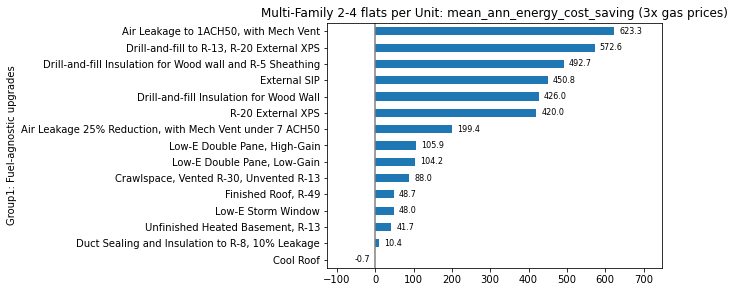

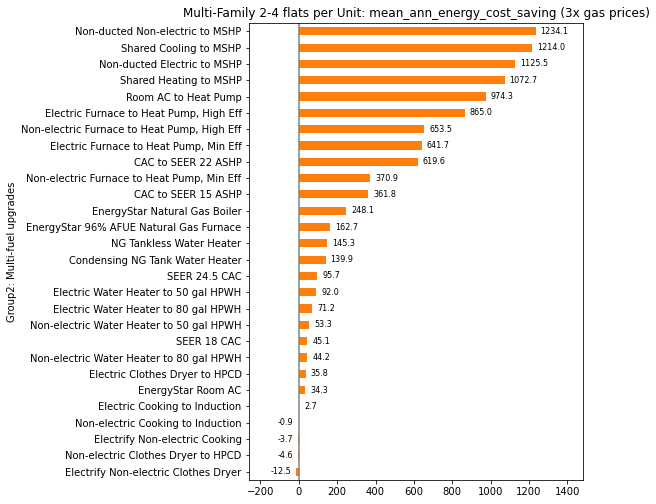

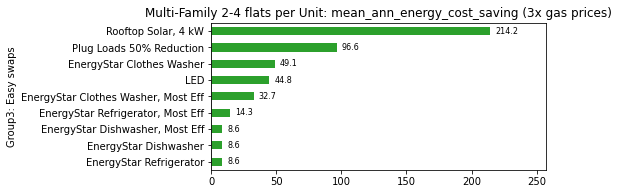

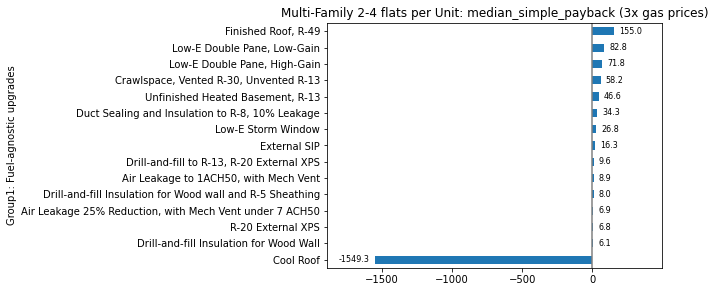

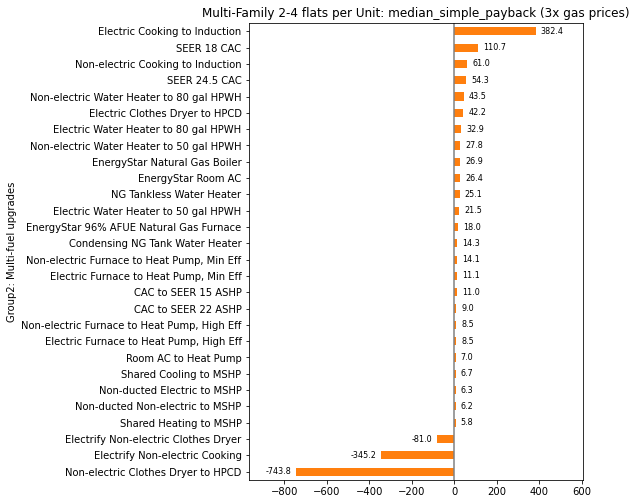

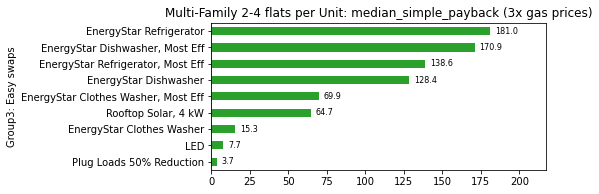

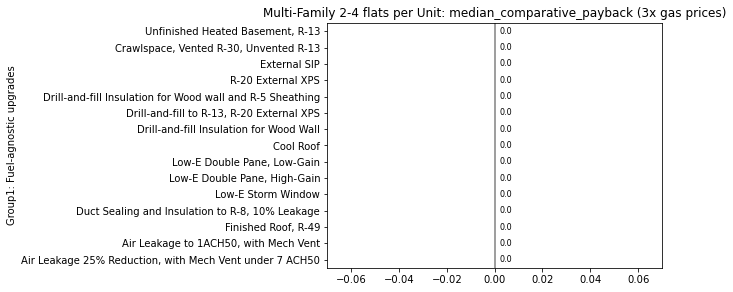

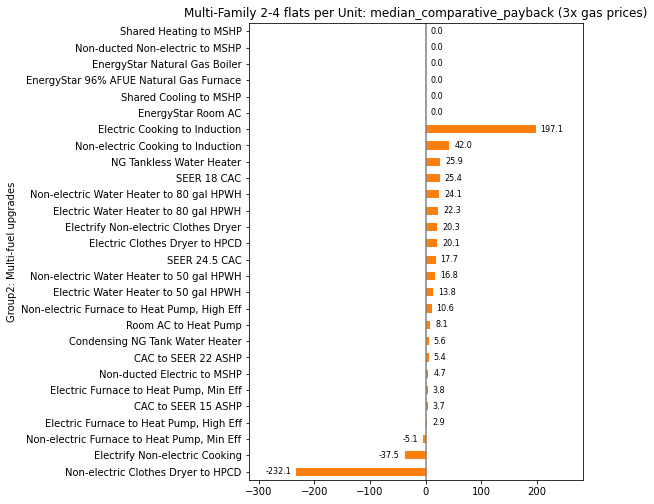

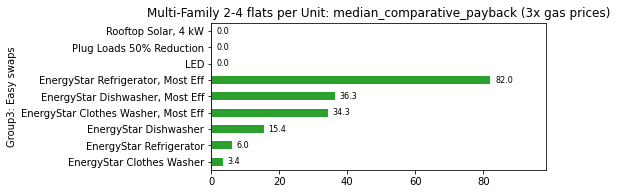

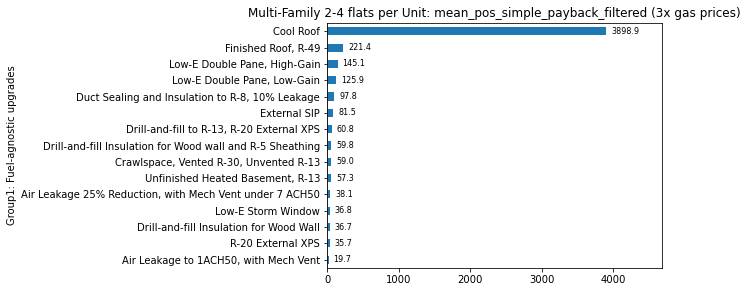

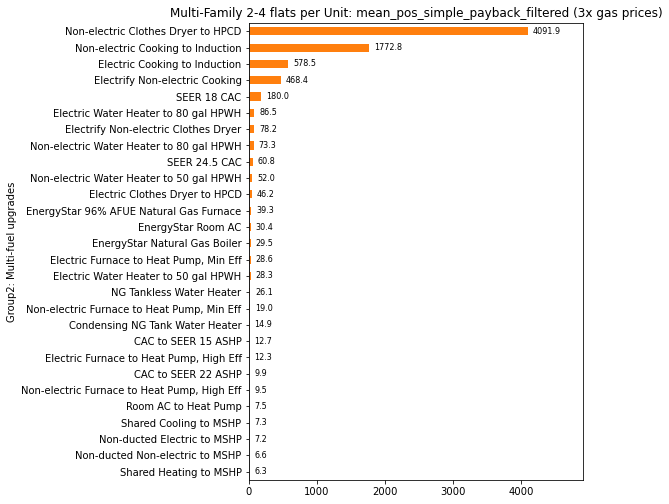

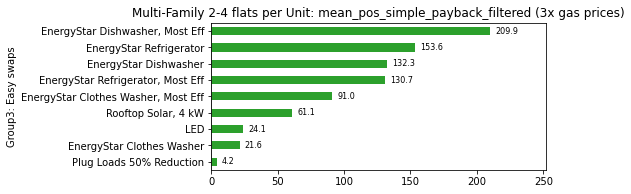

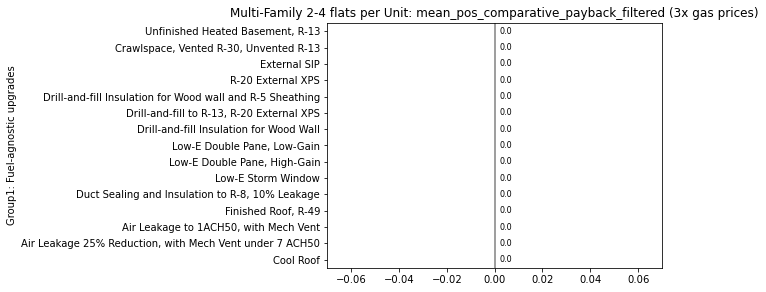

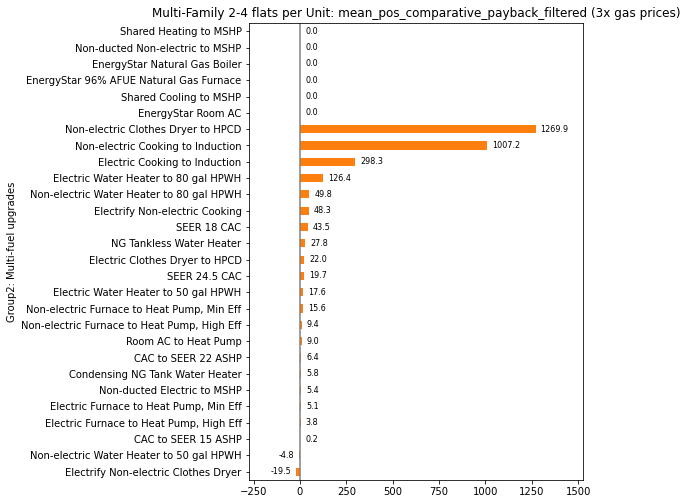

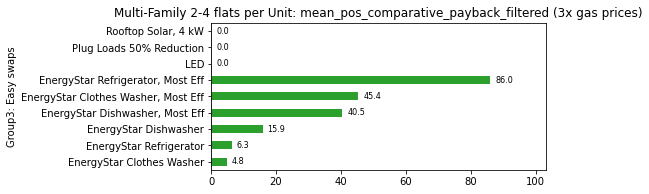

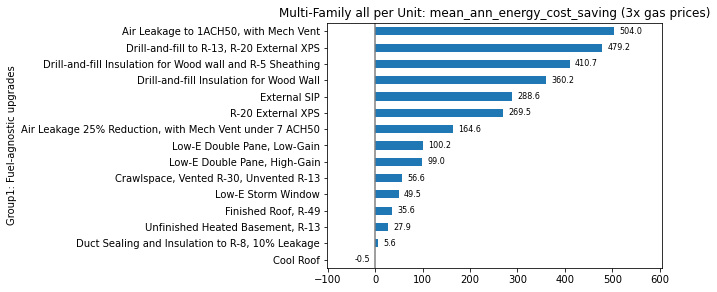

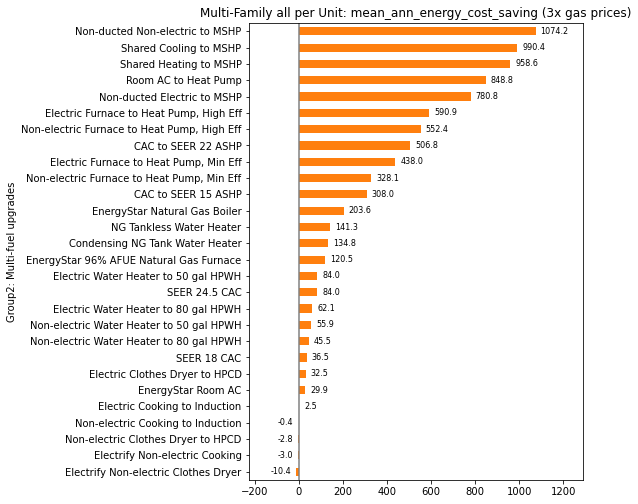

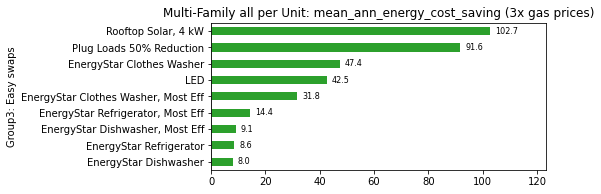

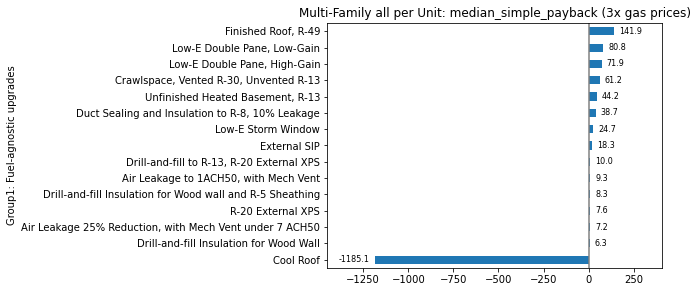

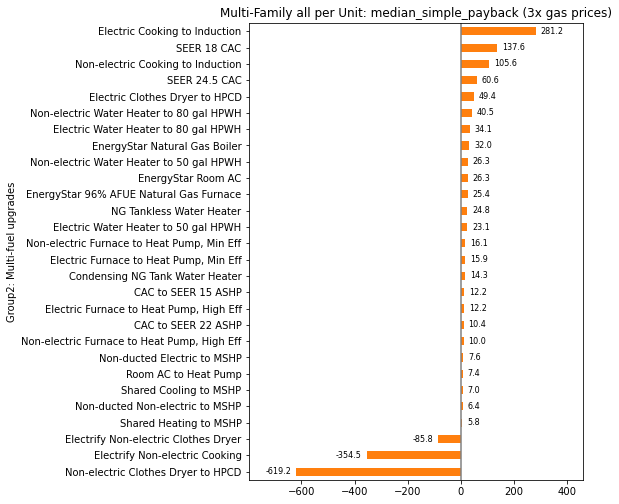

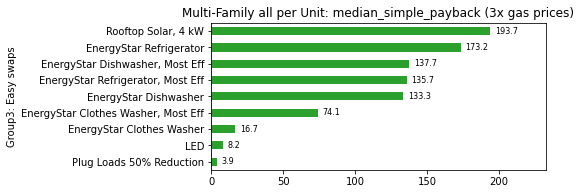

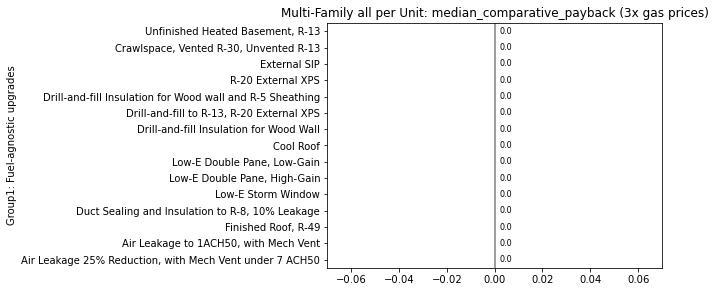

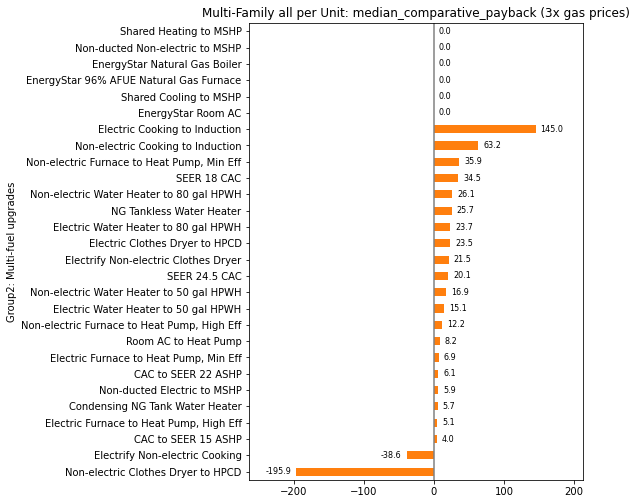

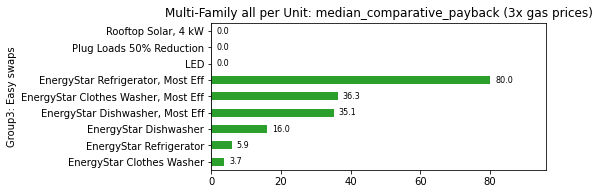

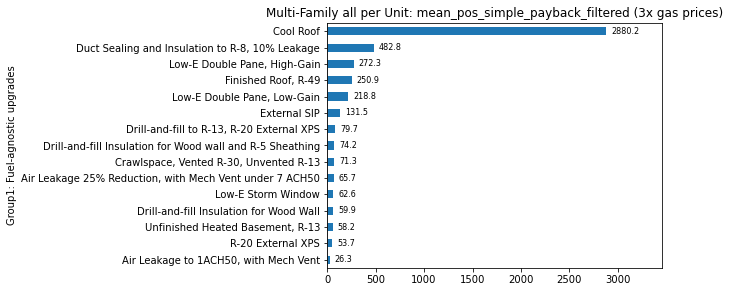

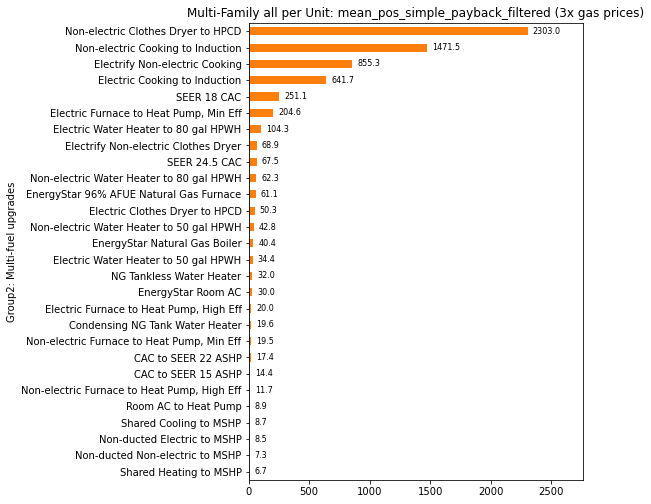

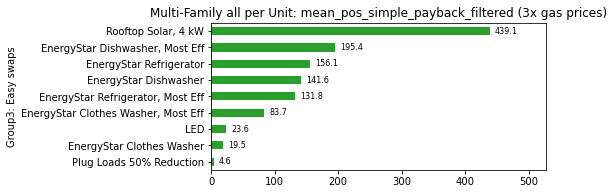

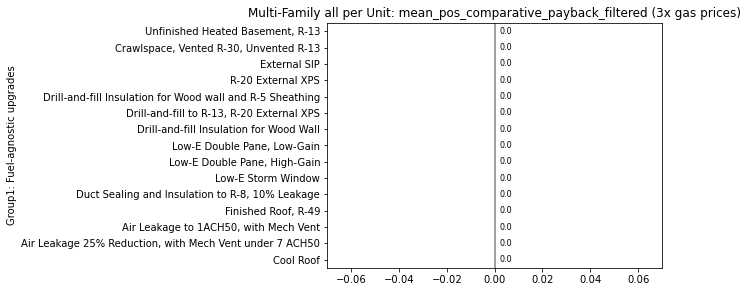

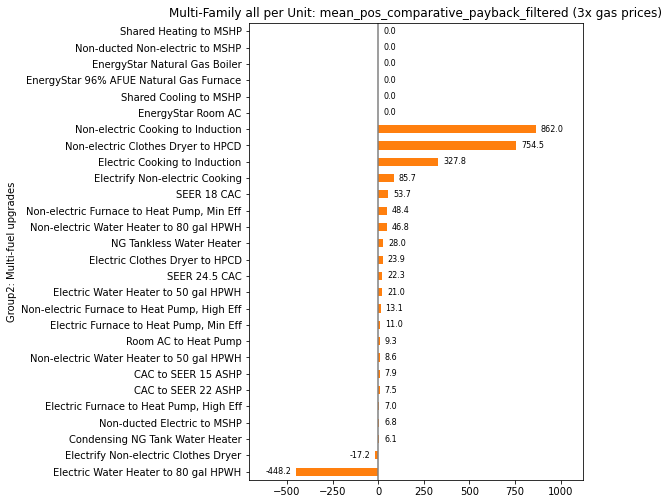

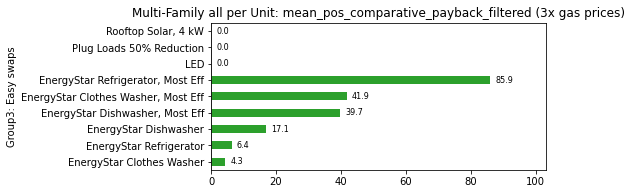

In [63]:
### plot MF-all & MF-2-4 flats (Cook County Avg) ###

for mf_type in summary_upgrades['mf_type'].unique():
    summ_ups = summary_upgrades[
        (~summary_upgrades['upgrade_no'].isnull()) & (summary_upgrades['mf_type']==mf_type)
         ].reset_index(drop=True)

    upgrade_sets = {
        'Group1: Fuel-agnostic upgrades': range(1, 16),
        'Group2: Multi-fuel upgrades': range(16, 44),
        'Group3: Easy swaps': range(44, 53),
    }
    upgrade_set_colors = {
        'Group1: Fuel-agnostic upgrades': 'tab:blue',
        'Group2: Multi-fuel upgrades': 'tab:orange',
        'Group3: Easy swaps': 'tab:green',
    }

    # create subfolder for plots:

    plot_path5 = os.path.join(plot_path, f'mean_values_mf_{mf_type}_cook_cnty_avg')
    if not os.path.exists(plot_path5):
        os.mkdir(plot_path5)
    print(f'plot dir: {plot_path5}\n')

    if NG_rate_multiplier == 1: 
        metrics_to_plot = list(x for x in summary_upgrades.columns if 
                               x.startswith('mean') or x.startswith('median'))
    else:
        metrics_to_plot = ['mean_ann_energy_cost_saving', 
                           'median_simple_payback',
                           'median_comparative_payback',
                           'mean_pos_simple_payback_filtered',
                           'mean_pos_comparative_payback_filtered']

    for metric in metrics_to_plot:
        title_ext = '' if fn_ext == '' else f' ({fn_ext.replace("_"," ").lstrip()})'
        title = f'Multi-Family {mf_type} per Unit: {metric}{title_ext}'
        print(f'Plotting {title}...')

        for n, up in enumerate(upgrade_sets.keys(),1):
            print(f'    - Group{n}')

            groupi = summ_ups.loc[
                summ_ups['upgrade_no'].isin(upgrade_sets[up]),
                ['upgrade_name', metric]
            ].set_index(['upgrade_name']).replace([np.inf, -np.inf], np.nan)
            
            if metric == 'median_comparative_payback':
                groupi = groupi.replace(0,np.nan).sort_values(by = metric) # make 0 nan
            else:
                groupi = groupi.sort_values(by = metric)
            groupi.index.name = up

            ht = len(groupi)
            fig, ax = plt.subplots(figsize=(6, 0.3*ht))
            groupi.plot.barh(color=upgrade_set_colors[up], legend=False, title=title, ax=ax)

            # For each bar: Place a label ############################
            rects = ax.patches
            for rect in rects:
                # Get X and Y placement of label from rect.
                x_value = rect.get_width()
                y_value = rect.get_y() + rect.get_height() / 2

                # Number of points between bar and label. Change to your liking.
                space = 5
                # Vertical alignment for positive values
                ha = 'left'

                # If value of bar is negative: Place label left of bar
                if x_value < 0:
                    # Invert space to place label to the left
                    space *= -1
                    # Horizontally align label at right
                    ha = 'right'

                # Use X value as label and format number with one decimal place
                label = "{:.1f}".format(x_value)

                # Create annotation
                plt.annotate(
                    label,                      # Use `label` as label
                    (x_value, y_value),         # Place label at end of the bar
                    xytext=(space, 0),          # Horizontally shift label by `space`
                    textcoords="offset points", # Interpret `xytext` as offset in points
                    va='center',                # Vertically center label
                    ha=ha,                      # Horizontally align label differently for
                    fontsize=8)                 # positive and negative values. 

            ax.margins(x=0.2)    
            ax.axvline(x=0, linestyle='-', color='gray')
            if (metric[-3:]=='eui') & (ax.get_xlim()[0] < -50):
                ax.axvline(x=-50, linestyle='--', color='darkred')
            
            filename = f'MF-{mf_type}_upgrades_{iteration}_{metric[5:]}_group{n}{fn_ext}.pdf'
            fig.savefig(os.path.join(plot_path5, filename),
                        bbox_inches='tight')
        